# Code 

In [2]:
import kwant
from kwant.digest import uniform    # a (deterministic) pseudorandom number generator
import numpy as np
import math
from math import atan2, pi, sqrt, cos, sin, tanh
from cmath import exp
from types import SimpleNamespace
import matplotlib
from matplotlib import pyplot as plt
from ipywidgets import interact
from matplotlib import ticker, cm
import time

from pylab import rcParams
rcParams['figure.figsize'] = 5,5

In [3]:
h = 6.626069e-34    # Planck constant (Js)
e = 1.602e-19      # electron charge (C)
c = 299792458       # Light celerity (m/s)
kB = 1.3806503e-23  # Boltzmann constant (kg m2/Ks2)
m_e = 9.1e-31       # electron mass (kg)
h_bar = h/(2*math.pi)
phi_0 = h/e #quantum de flux
k=0

## Système de simulation

Ici nous avons implémenté une jonction PP ou PN. La largeur de la zone de dépletion est contrôlée par une fonction
tangeante hyperbolique avec le paramètre $w$. La densité dans la deuxième zone est contrôlée par la variable n. Ses différentes valeurs sont détaillées dans les commentaires ci-dessous nous.

In [5]:
def onsite(site):
    """
    potentiel de jonction pp
    """
    
    (x, y) = site.pos
    eta = -((y/10e-9)+1)

    if w == 0:
            return 0
    else:
        return -abs(Ef)*n/2*(math.tanh(eta*w)+ 1 )
    '''
    Jonction pp' (p'<p)
    0<n<1
    (p'>p)
    n>0
    
    Jonction pn'
    n<1
    
    Jonction pn
    n=2
    w = pente
    '''

Pour rendre compte du champ magnétique, nous avons utilisé la substitution de Peier, dans le modèle "tight-binding"

In [6]:
def hopping(site_i, site_j):
    """
    Definition of the hopping parameter by including the magnetic field (parameter phi)

    """

    xi, yi = site_i.pos
    xj, yj = site_j.pos
    delta = (xi - xj) * (yi + yj)
    return -t * exp(-1j * math.pi * (phi/phi_0)* delta /( 3*np.sqrt(3)/(2) *alat**2))

Le champ magnétique induit un changement de phase proportionnel au potentiel vecteur A, lors d'un saut entre sites $i$ et $j$:

$$t_{ij} \rightarrow t_{ij} \times \exp\left(i \frac{e}{\hbar} \int_{\mathbf{x}_j}^{\mathbf{x}_i} \mathbf{A}(\mathbf{x}) d\mathbf{s}\right)$$

Pour un champ selon l'axe z dans notre modèle bi-dimensionnel, l'intégrale devient:

$$\exp\left(i\, \frac{e}{\hbar} B \frac{(y_i + y_j)}{2} (x_i-x_j)\right)$$



$$\exp\left(i\, 2 \pi \frac{\phi}{\phi_0} \frac{(y_i + y_j)(x_i-x_j)}{A_{lattice}} \right)$$

avec  $\phi = B A_{lattice}^2$, flux magnétique à travers un "hexagone" et $\phi_0 = h/e$ le quantum de flux.

## Système numérique

Notre principale difficulté fut de construire un système cohérent avec le dispositif expérimental de l article en conservant un temps raisonnable de simulation en ne mettant pas trop de sites. Pour cela, nous avons du introduire un facteur d'échelle, qui nous permet d'augmenter la taille du système. En effet, nous utilisons un graphène théorique où la distance $a$ séparant deux sites serait multipliée par ce facteur $sf$. Nous devons donc également  modifier l'énergie de saut de la sorte:
$$a = s_fa_0$$
$$t = \frac{t_0}{sf}$$

Pour conserver une certaine cohérence, nous avons choisi de diviser également l'énergie de Fermi des électrons par ce facteur, ceci afin de rester dans un régime ballistique. Finalement, nous avons un système de l'ordre du centième de micron. En comparaison le système expérimental est de l'ordre du micron. 

Nous avons également attaché 4 leads au système. Les électrons sont envoyés depuis le lead supérieur droit. La structure et le champ magnétique détermineront l'endroit d'arrivée des électrons. Les leads ne doivent pas être trop fins, sans quoi le nombre de modes électroniques 

L'énergie de fermi est calculée d'après sa formule, reliant la densité de porteurs dans le graphène à l'énergie:
$$n_s = (E/at)^{2}\frac{8}{9π} $$
Cependant, nous ne sommes pas libre de choisir nos densités de manière arbitraire. En effet, la condition:
$$\lambda_f <<< a$$
Induit une condition sur l'énergie du système:
$$|E_f| <<< \frac{3 \pi t_0}{s_f}$$

Nous n'avons donc pas pu utiliser les densités du système car elles donnaient une énergie trop grande. Etant donné le sens arbitraire de la conditon <<<<, il a fallu procéder à une analyse ad-hoc. Nous avons finalement retenu les énergies donnant lieu à un régime ballistique, ceci en analysant les densités de courant.

In [7]:
def make_system(alat=1,W=1,L=1,t=1.0, h_l= 10, w_l=10,d_armEdge=10):
    graphene = kwant.lattice.honeycomb(alat,norbs=1)
    a, b = graphene.sublattices
    sys = kwant.Builder()
 
    def rectangular(pos):
        x, y = pos
        if (L-h_l)/2 < abs(y) < (L)/2:
            return abs(y) < (L)/2 and abs(x) < (W+w_l)/2
        return abs(x) < (W)/2 and abs(y) < (L+d_armEdge)/2 
    def lead_shape1(pos):
        x, y = pos
        return (L-h_l)/2 < abs(y) < L/2
  
    def lead_shape2(pos):
        x, y = pos
        return -W/2 < x < W/2
    
   
    
    sys[graphene.shape(rectangular, (0,0))] = onsite
    hoppings = (((0, 0), a, b), ((0, 1), a, b), ((-1, 1), a, b))
    sys[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings]] = hopping

    sym0 = kwant.TranslationalSymmetry(graphene.vec((-1, 0)))
    lead0 = kwant.Builder(sym0)
    lead0[graphene.shape(lead_shape1, (0, L/2))] = -pot
    lead0[graphene.neighbors()]= hopping
    sys.attach_lead(lead0)
    #sys.attach_lead(lead0.reversed())
    sys.attach_lead(lead0.reversed())
    
    sym1 = kwant.TranslationalSymmetry(graphene.vec((-1, 0)))
    lead1 = kwant.Builder(sym1)
    lead1[graphene.shape(lead_shape1, (0, -L/2))] = -pot
    lead1[graphene.neighbors()]= hopping
    sys.attach_lead(lead1)
    sys.attach_lead(lead1.reversed())
    
    return sys

### Valeurs et constantes

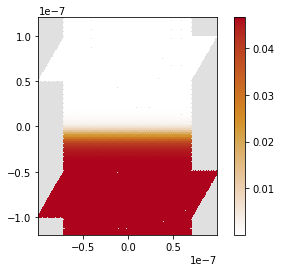

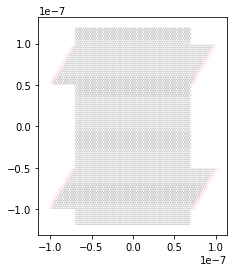

In [9]:
#Constants and system parameters

a0 = 0.142e-9  # lattice parameter
sf = 20 #scaling factor
alat = sf*a0 #scaled lattice factor
t0 = 2.8 ; #true hopping energy
t = t0/sf #scaled hopping energy
W = 7e-9*sf; L = 10e-9*sf # width and length of the electronic system: ordre de dimension 10e-7

N_p = -19.5e16 #carrier densité (1/m²)
Ef = -(3/2) * t * (alat) * np.sqrt(abs(np.pi*N_p))/sf #Fermi energy in graphene regarding electronic density
h_l = 5e-9*sf ; w_l = 0*sf ; d_armEdge =2e-9*sf #paramètres des noeuds


w=1 
sys = make_system(alat,W,L,t, h_l, w_l,d_armEdge)
n= -2
kwant.plotter.map(sys, onsite)
sys = sys.finalized()

kwant.plot(sys, site_size=alat)
B_coef = 4*2*h_bar*math.sqrt(math.pi)/(e*L)*10e13
Field = np.linspace(0, -1, 50)


Ci dessus, le plan du système ainsi que la représentation graphique de la densité de porteurs sur le site.

### Energies

In [11]:
""" The wavelength must be (much more) larger than the lattice parameter """
lambda_F = 3 * pi * alat * t / Ef # computation of the wavelength in graphene
print('Fermi wavelength: ', lambda_F)
print('Scaled lattice parameter: ', alat)
if lambda_F/alat < 2:
    print('Warning : lambda_F must be larger than the lattice parameter alat')
    
""" We must be at low energy density at the level of the Dirac cone """
print('Fermi energy Ef: ', Ef, "eV")
print('Maximal energy according to the scalable model :', 3*t0*math.pi/sf)
print('Scaled hopping energy: ', t, 'eV')
if abs(Ef/t) > (1/2):
    print('Warning : Ef must be smaller than (1/2)t')

Fermi wavelength:  -1.6055270315691722e-07
Scaled lattice parameter:  2.84e-09
Fermi energy Ef:  -0.023339947839678944 eV
Maximal energy according to the scalable model : 1.319468914507713
Scaled hopping energy:  0.13999999999999999 eV


## MAP (différence de transmission)

In order to see resonant path, we need to compute the non-local resistance between (in arbitrary units) the two leads in the second part of the system. Resistance extrema correspond to a resonant state, in respect to magnetic field and carrier density. 

To compute the non-local resistance, we have to compute the S-matrix then the conductance matrix, thanks to the kwant function $conductance_matrix$. Because we have 4 leads, we eliminate a column and a ligne. This sets the voltage in the last lead to zero. Then we set the current flowing from lead 0 (start lead) to lead 1 (the opposite), and compute the voltage in lead 3. This will give us the tension between the two terminal leads, as V4 = 0. Then we have the non-local resistance, in arbitrary units. 


Temps écoulé:  0.0002377033233642578
0.0 %
Temps écoulé:  60.7985520362854
1.0 %
Temps écoulé:  124.85430693626404
2.0 %
Temps écoulé:  187.61331605911255
3.0 %
Temps écoulé:  251.82158994674683
4.0 %
Temps écoulé:  315.95918464660645
5.0 %
Temps écoulé:  378.5776536464691
6.0 %
Temps écoulé:  442.13749718666077
7.0 %
Temps écoulé:  507.2776458263397
8.0 %
Temps écoulé:  571.2151701450348
9.0 %
Temps écoulé:  634.4755403995514
10.0 %
Temps écoulé:  697.4289536476135
11.0 %
Temps écoulé:  761.0508213043213
12.0 %
Temps écoulé:  823.7621374130249
13.0 %
Temps écoulé:  879.305388212204
14.0 %
Temps écoulé:  930.658408164978
15.0 %
Temps écoulé:  981.8645815849304
16.0 %
Temps écoulé:  1032.9849407672882
17.0 %
Temps écoulé:  1084.2533004283905
18.0 %
Temps écoulé:  1135.3341159820557
19.0 %
Temps écoulé:  1186.6317615509033
20.0 %
Temps écoulé:  1237.864737033844
21.0 %
Temps écoulé:  1288.9822885990143
22.0 %
Temps écoulé:  1340.1898350715637
23.0 %
Temps écoulé:  1391.2443499565125
24.0

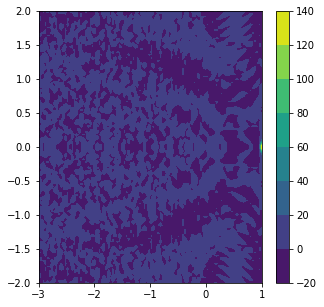

Temps d'exécution:  5293.422605276108


In [120]:
N= 100
Field = np.linspace(-2, 2, N)
Jonction = np.linspace(-2,2,N)
T2 = np.zeros((N,N))
start_time = time.time()
for i, I in enumerate(Field):

        print('Temps écoulé: ',time.time() - start_time)
        phi = I * 3*np.sqrt(3)/(2) *alat**2
        print(i*100/N, '%')
        for j, B in enumerate(Jonction):
            n = B
            smatrix = kwant.smatrix(sys, energy = Ef) # transmission matrix (here this)
            # In order to calculate the nonlocal conductance we eliminate one row and one column 
            # from the condutcance matrix. This amounts to setting the corresponding voltage to zero 
            # and using current conservation to calculate the current through the last terminal.
            cm = smatrix.conductance_matrix()[:-1, :-1]
        

            n2 = np.linalg.solve(cm, [1, -1 , 0])[2]
            T[i,j] = n2


plt.contourf(Jonction, Field, T2);
plt.colorbar()
plt.show()
interval = time.time() - start_time  
print('Temps d\'exécution: ', interval)

In [12]:
levels=np.linspace(-0.4,0.4,50)

plt.contourf(Jonction, Field, T,levels=levels, cmap='bwr');
plt.colorbar()
plt.xlabel("Densité électronique")
plt.ylabel("Champ magnétique")

plt.show()

NameError: name 'Jonction' is not defined

In [54]:
f = open('map.txt','a')
f.write(str(Jonction))
f.write('\n Champ \n')
f.write(str( Field))
f.write('\n Transmission \n')
f.write(str(T))
f.close()


In [314]:
N= 50
Field = np.linspace(0, -2, N)
Jonction = np.linspace(-1,1,N)
T = np.zeros((N,N))
for i, I in enumerate(Jonction):
        n = I
        for j, B in enumerate(Field):
            phi = B * 3*np.sqrt(3)/(2) *alat**2
            smatrix = kwant.smatrix(sys, energy = Ef) # transmission matrix (here this)
            T2 = smatrix.transmission(2,0)
            T3 = smatrix.transmission(3,0)# transmission value obtained from the left lead towards the right lead
            T[i,j] = T2-T3
X = Jonction
Y = Field
plt.contourf(Jonction, Field, T)
    
    

KeyboardInterrupt: 